In [1]:
# from getopt import getopt
# import cloudpickle
# import pickle
# import sys
# import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import logit, expit
from scipy.stats import uniform, norm, bernoulli
from scipy.stats import linregress
# from statsmodels.stats.proportion import proportions_ztest
from matplotlib import pyplot as plt
import pymc as pm
import arviz as az
from modeltools import mcmc_diagnostics, create_summary_stat
from downcast import downcast_df
import jax
from pymc.sampling_jax import sample_numpyro_nuts
# from time import time, sleep
# from datetime import timedelta

/home/roger/anaconda3/envs/bayes_topic_measures/lib/python3.10/site-packages/pymc/sampling_jax.py:37: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Checking pval

In [2]:
oa0_test_results = (pd.read_csv("data/simulations/oa0_test.csv")
                    .sort_values("sim_id")
                    .reset_index()
                    .drop(columns="index"))
oa1_test_results = (pd.read_csv("data/simulations/oa1_test.csv")
                    .sort_values("sim_id")
                    .reset_index()
                    .drop(columns="index"))

In [3]:
print("Checking if all values for the following columns match\n")
for c in ["p_diff", "n_raters", "scores_per_r", "total_scores", "seed"]:
    print(c, all(oa0_test_results[c]==oa1_test_results[c]))

Checking if all values for the following columns match

p_diff True
n_raters True
scores_per_r True
total_scores True
seed True


In [4]:
a=oa0_test_results
b=oa1_test_results.rename(columns={"propz_pval":"propz_pvalOA", "bht_pval":"bht_pvalOA"})
c=pd.merge(a,b[["sim_id", "propz_pvalOA", "bht_pvalOA"]],on="sim_id")
c = c[["sim_id", "trial_id", "p_diff", "n_raters", "scores_per_r", "total_scores", 
       "seed", "propz_pval", "propz_pvalOA", "bht_pval", "bht_pvalOA"]]
c["propz_OA_factor"]=c["propz_pvalOA"]/c["propz_pval"]
c["propz_OA_factor"] = c["propz_OA_factor"].round(4)
c["bht_OA_factor"]=c["bht_pvalOA"]/c["bht_pval"]



In [5]:
c.sort_values("total_scores")[-50:]

,sim_id,trial_id,p_diff,n_raters,scores_per_r,total_scores,seed,propz_pval,propz_pvalOA,bht_pval,bht_pvalOA,propz_OA_factor,bht_OA_factor
8,8,0,0.055,55,35,1925,50,2.742224e-04,2.084090e-06,0.009,0.002,7.600000e-03,0.222222
1,1,0,0.055,56,35,1960,43,1.067728e-06,6.106063e-02,0.000,0.001,5.718742e+04,inf
4,4,0,0.055,57,35,1995,46,5.333170e-02,1.858353e-01,0.011,0.076,3.484500e+00,6.909091
65,65,0,0.055,60,35,2100,107,6.474827e-03,6.116449e-01,0.001,0.155,9.446500e+01,155.000000
64,64,0,0.055,60,35,2100,106,1.404406e-05,7.389630e-03,0.000,0.035,5.261748e+02,inf
36,36,0,0.055,60,35,2100,78,9.096020e-03,1.694734e-02,0.002,0.001,1.863200e+00,0.500000
37,37,0,0.055,61,35,2135,79,3.937746e-04,7.483884e-03,0.000,0.002,1.900550e+01,inf
46,46,0,0.055,65,35,2275,88,1.188910e-02,2.955525e-02,0.039,0.004,2.485900e+00,0.102564
56,56,0,0.055,65,35,2275,98,1.414805e-01,3.913595e-01,0.030,0.051,2.766200e+00,1.700000
27,27,0,0.055,69,35,2415,69,8.404059e-02,2.936442e-02,0.010,0.188,3.494000e-01,18.800000


In [14]:
linregress(c["n_raters"], np.log(c["bht_pval"]+0.0001))

LinregressResult(slope=-0.032072504655767935, intercept=-3.101879900579974, rvalue=-0.4035439854221394, pvalue=0.000644017927692732, stderr=0.008951014386886839, intercept_stderr=0.8174547166247317)

In [15]:
linregress(c["n_raters"], np.log(c["bht_pvalOA"]+0.0001))

LinregressResult(slope=-0.027633771138296896, intercept=-2.5619526769806846, rvalue=-0.35794564693609493, pvalue=0.0027269613668220193, stderr=0.008873157583722365, intercept_stderr=0.8103444151307065)

## Checking scores

In [79]:
sim_id = 47
test = pd.read_csv(f"data/oa0_test/score_{sim_id}.csv")
testOA = pd.read_csv(f"data/oa1_test/score_{sim_id}.csv")

In [3]:
# Checking how many times are topics rated in oa0_test
(test.groupby("sim_topic_id")
 .agg({"intrusion":["sum", "count"]})
 .reset_index()
 .sort_values(("intrusion", "count")))

sim_topic_id intrusion      
                      sum count
0             0        39    47
69           69        43    47
66           66        34    47
65           65        40    47
64           64        32    47
..          ...       ...   ...
68           68        41    48
67           67        32    48
60           60        29    48
10           10        42    48
49           49        36    48

[100 rows x 3 columns]

In [4]:
# Checking how many times are topics rated in oa0_test vs p
(testOA.groupby("sim_topic_id")
 .agg({"intrusion":["sum", "count"]})
 .reset_index()
 .sort_values(("intrusion", "count")))

sim_topic_id intrusion      
                      sum count
99           99        14    14
32           32        14    14
36           36        14    14
41           41        14    14
52           52        14    14
..          ...       ...   ...
61           61        32    62
95           95        29    62
1             1        34    62
28           28        30    62
34           34        33    62

[100 rows x 3 columns]

In [5]:
b = testOA
for c in b:
    b=b.rename(columns={c:c+"OA"})
    
a = pd.merge(test, b, left_on=["sim_topic_id", "sim_rater_id"],
            right_on=["sim_topic_idOA", "sim_rater_idOA"], how="inner")

print(f"number of rater/score interactions in common: {len(a)}")
print(f"number of rater/score interactions the same: {sum(a['intrusion']==a['intrusionOA'])}")

number of rater/score interactions in common: 1519
number of rater/score interactions the same: 1519


## Inference

In [60]:
test.loc[test["sim_cordel_id"]==1, "sim_topic_id"]-=50
testOA.loc[testOA["sim_cordel_id"]==1, "sim_topic_id"]-=50

In [80]:
test.loc[:,"sim_topic_id"] = np.where(test["sim_topic_id"] >= 50
                                 ,test["sim_topic_id"]-50
                                 ,test["sim_topic_id"])


In [81]:
testOA.loc[:,"sim_topic_id"] = np.where(testOA["sim_topic_id"] >= 50
                                 ,testOA["sim_topic_id"]-50
                                 ,testOA["sim_topic_id"])


In [88]:
n_chains = 2
seed = 41+sim_id
# seed = 21

SAMPLE_JAX = True
chain_method = "vectorized"

In [89]:
sample = test
glm_test = {"model":pm.Model()}
glm = glm_test

In [90]:
# sample = scores[scores["trial_id"]==0]
if seed != None:
    np.random.seed(seed)

# Bayesian hypothesis tests whether the two distributions in the sample are statisticaly significant
# Setting up numpy arrays for pymc
# Only 2 models and 1 corpus in simulation
corpus_array = np.array([0]*len(sample))
n_corpora = 1

model_array = np.array(sample["sim_cordel_id"])
n_models = sample["sim_cordel_id"].nunique()

cordel_array = np.array(sample["sim_cordel_id"])
n_cordels = sample["sim_cordel_id"].nunique()

topic_array = np.array([sample["sim_cordel_id"], sample["sim_topic_id"]])
n_topics = sample["sim_topic_id"].nunique()

rater_array = np.array(sample["sim_rater_id"])
n_raters = sample["sim_rater_id"].nunique()

score_array = np.array(sample["intrusion"])

# Model and MCMC specifications
empirical_mean = logit(0.75)
r_lambda = 2
t_lambda = 1
t_sigma = 1
# cm_lambda = 2
# cm_sigma = 1
mu_sigma = 1

# Rater, Topic, Cordel model

glm["model"] = pm.Model()
with glm["model"]:
    # Hyperparameter priors
    raters = pm.Data("raters", rater_array, mutable=True, dims="obs_id")
    topics = pm.Data("topics", topic_array, mutable=True, dims=["cordel", "topic"])
    cordels = pm.Data("cordels", cordel_array, mutable=True, dims="obs_id")

    sigma_r = pm.Exponential("sigma_r", lam=r_lambda)
    zr = pm.Normal("zr",mu=0, sigma=1, shape=n_raters)
    sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
    za = pm.Normal("za",mu=0, sigma=t_sigma, shape=(n_cordels, n_topics)) 
    mu = pm.Normal("mu",mu=empirical_mean, sigma=mu_sigma, shape=n_cordels)

    s = pm.Bernoulli(
            "s", 
            p=pm.math.invlogit(
                mu[cordels]+
                za[topics[0],topics[1]]*sigma_a+
                zr[raters]*sigma_r),
            observed=score_array, 
            dims="obs_id")
    
    c_mean0 = pm.Deterministic("c_mean0", mu[0] + za[0,:].mean()*sigma_a)
    c_mean1 = pm.Deterministic("c_mean1", mu[1] + za[1,:].mean()*sigma_a)
    c_diff = pm.Deterministic("c_diff", c_mean1 - c_mean0)
#     c_mean = pm.Deterministic("c_mean", 
#                               pm.math.invlogit(mu + (za.T*sigma_a)).mean(axis=0), 
#                               dims="obs_id")
#     c_diff = pm.Deterministic("c_diff", c_mean.reshape([n_cordels,1]) - c_mean.reshape([1,n_cordels]), dims="obs_id")

    if SAMPLE_JAX:
        glm["trace"]=sample_numpyro_nuts(chains=n_chains, random_seed=np.random.randint(2**20), chain_method=chain_method)
    else:
        glm["trace"]=pm.sample(chains=n_chains, random_seed=np.random.randint(2**20))

# n_negatives = (glm["trace"].posterior["c_diff"].sel({"obs_id":1, "c_diff_dim_1":0}) < 0).sum().item()

#     return  n_negatives/len(sample)

Compiling...
Compilation time =  0:00:01.031464
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:52<00:00, 38.36it/s]


Sampling time =  0:00:52.404112
Transforming variables...
Transformation time =  0:00:00.071378
Computing Log Likelihood...
Log Likelihood time =  0:00:01.255598


In [91]:
# Repeate code below again for OA settings
sample = testOA
glm_testOA = {"model":pm.Model()}
glm = glm_testOA

In [ ]:
# sample = scores[scores["trial_id"]==0]
if seed != None:
    np.random.seed(seed)

# Bayesian hypothesis tests whether the two distributions in the sample are statisticaly significant
# Setting up numpy arrays for pymc
# Only 2 models and 1 corpus in simulation
corpus_array = np.array([0]*len(sample))
n_corpora = 1

model_array = np.array(sample["sim_cordel_id"])
n_models = sample["sim_cordel_id"].nunique()

cordel_array = np.array(sample["sim_cordel_id"])
n_cordels = sample["sim_cordel_id"].nunique()

topic_array = np.array([sample["sim_cordel_id"], sample["sim_topic_id"]])
n_topics = sample["sim_topic_id"].nunique()

rater_array = np.array(sample["sim_rater_id"])
n_raters = sample["sim_rater_id"].nunique()

score_array = np.array(sample["intrusion"])

# Model and MCMC specifications
empirical_mean = logit(0.75)
r_lambda = 2
t_lambda = 1
t_sigma = 1
# cm_lambda = 2
# cm_sigma = 1
mu_sigma = 1

# Rater, Topic, Cordel model

glm["model"] = pm.Model()
with glm["model"]:
    # Hyperparameter priors
    raters = pm.Data("raters", rater_array, mutable=True, dims="obs_id")
    topics = pm.Data("topics", topic_array, mutable=True, dims=["cordel", "topic"])
    cordels = pm.Data("cordels", cordel_array, mutable=True, dims="obs_id")

    sigma_r = pm.Exponential("sigma_r", lam=r_lambda)
    zr = pm.Normal("zr",mu=0, sigma=1, shape=n_raters)
    sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
    za = pm.Normal("za",mu=0, sigma=t_sigma, shape=(n_cordels, n_topics)) 
    mu = pm.Normal("mu",mu=empirical_mean, sigma=mu_sigma, shape=n_cordels)

    s = pm.Bernoulli(
            "s", 
            p=pm.math.invlogit(
                mu[cordels]+
                za[topics[0],topics[1]]*sigma_a+
                zr[raters]*sigma_r),
            observed=score_array, 
            dims="obs_id")
    
    c_mean0 = pm.Deterministic("c_mean0", mu[0] + za[0,:].mean()*sigma_a)
    c_mean1 = pm.Deterministic("c_mean1", mu[1] + za[1,:].mean()*sigma_a)
    c_diff = pm.Deterministic("c_diff", c_mean1 - c_mean0)
#     c_mean = pm.Deterministic("c_mean", 
#                               pm.math.invlogit(mu + (za.T*sigma_a)).mean(axis=0), 
#                               dims="obs_id")
#     c_diff = pm.Deterministic("c_diff", c_mean.reshape([n_cordels,1]) - c_mean.reshape([1,n_cordels]), dims="obs_id")

    if SAMPLE_JAX:
        glm["trace"]=sample_numpyro_nuts(chains=n_chains, random_seed=np.random.randint(2**20), chain_method=chain_method)
    else:
        glm["trace"]=pm.sample(chains=n_chains, random_seed=np.random.randint(2**20))

# n_negatives = (glm["trace"].posterior["c_diff"].sel({"obs_id":1, "c_diff_dim_1":0}) < 0).sum().item()

#     return  n_negatives/len(sample)

Compiling...
Compilation time =  0:00:01.213129
Sampling...


  0%|                                                  | 0/2000 [00:00<?, ?it/s]

In [ ]:
n_neg_test = (glm_test["trace"].posterior["c_diff"]<0).sum().item()
n_neg_testOA = (glm_testOA["trace"].posterior["c_diff"]<0).sum().item()
total = glm_test["trace"].posterior["c_diff"].count().item()
pval_test = n_neg_test/total
pval_testOA = n_neg_testOA/total
print(f"pval test: {pval_test}, pval testOA: {pval_testOA}")

In [51]:
glm_test["summary_stat"] = create_summary_stat(glm_test["trace"])
glm_testOA["summary_stat"] = create_summary_stat(glm_testOA["trace"])

# Deleting diagnostic columns
diag_cols = ['mcse_mean', 'mcse_sd', 'ess_bulk', 'ess_tail', 'r_hat']
glm_test["summary_stat"] = glm_test["summary_stat"].drop(columns=diag_cols)
glm_testOA["summary_stat"] = glm_testOA["summary_stat"].drop(columns=diag_cols)

# Creating Summary Stats
a = glm_test["summary_stat"]
b = glm_testOA["summary_stat"].rename(columns={c:c+"OA" for c in glm_testOA["summary_stat"].columns})
c = (pd.merge(a,b, left_on=["param", "param_num"], right_on=["paramOA", "param_numOA"])
       .drop(columns=["paramOA", "param_numOA"]))

In [27]:
c[c["param"]=="za"]

,param,param_num,mean,sd,hdi_3%,hdi_97%,meanOA,sdOA,hdi_3%OA,hdi_97%OA
135,za,"0, 0",0.4877,0.3295,-0.1378,1.1003,1.0530,0.5211,0.1386,2.0729
136,za,"0, 1",-0.4989,0.2786,-0.9858,0.0763,-0.6407,0.2854,-1.1720,-0.1077
137,za,"0, 2",0.8702,0.3657,0.1719,1.5483,1.0576,0.5352,0.0855,2.0650
138,za,"0, 3",-0.1139,0.2832,-0.6855,0.4037,-0.3193,0.2897,-0.8815,0.2132
139,za,"0, 4",-0.1037,0.3017,-0.6403,0.4891,0.5941,0.4331,-0.1572,1.4808
...,...,...,...,...,...,...,...,...,...,...
230,za,"1, 45",-0.0120,0.9702,-1.9886,1.6623,-1.0796,0.2731,-1.5770,-0.5875
231,za,"1, 46",-0.0130,1.0077,-1.9255,1.8332,-1.6521,0.3373,-2.3032,-1.0362
232,za,"1, 47",-0.0094,0.9982,-1.7957,1.9018,0.9508,0.5158,-0.0103,1.8654
233,za,"1, 48",0.0063,1.0209,-1.7615,2.0264,0.8776,0.5058,-0.0811,1.8214


In [20]:
c[c["param"].isin(["c_mean0", "c_mean1", "c_diff"])]

,param,param_num,mean,sd,hdi_3%,hdi_97%,meanOA,sdOA,hdi_3%OA,hdi_97%OA
239,c_mean0,NaN,1.0385,0.1416,0.7564,1.2930,0.9498,0.0815,0.8000,1.1023
240,c_mean1,NaN,1.2500,0.1451,0.9843,1.5254,1.1167,0.0838,0.9636,1.2704
241,c_diff,NaN,0.2115,0.1920,-0.1380,0.5810,0.1670,0.0907,-0.0142,0.3294


In [21]:
# Manual checking c_mean deterministic var calculations
za0 = c[(c["param"]=="za")&(c["param_num"].str[0]=="0")]["mean"].mean()
za1 = c[(c["param"]=="za")&(c["param_num"].str[0]=="1")]["mean"].mean()
mu0 = c[(c["param"]=="mu")&(c["param_num"]=="0")]["mean"].item()
mu1 = c[(c["param"]=="mu")&(c["param_num"]=="1")]["mean"].item()
sigma_a = c[c["param"]=="sigma_a"]["mean"].item()

mean0 = mu0+za0*sigma_a
mean1 = mu1+za1*sigma_a
print(f"{mean0=}, {mean1=}")

mean0=1.045947032, mean1=1.255679348


In [22]:
print(c[(c["param"]=="za")]["sd"].mean(), c[(c["param"]=="sigma_a")]["mean"].item())

0.665826 1.278


In [23]:
print(c[(c["param"]=="za")]["sdOA"].mean(), c[(c["param"]=="sigma_a")]["meanOA"].item())

0.3905779999999999 1.1332


## Testing variance as n_raters increase

In [ ]:
ss_OA = pd.DataFrame()
df = testOA

In [187]:
ss = pd.DataFrame()
df = test

In [188]:
summary_stats = ss
seed = 42+sim_id

for n_rater in range(55, 136, 10):
# n_raters = 100
    print(n_rater)
    sample = df[df["sim_rater_id"]<n_rater]
    sample.loc[:,"sim_topic_id"] = np.where(sample["sim_topic_id"] >= 50
                                     ,sample["sim_topic_id"]-50
                                     ,sample["sim_topic_id"])
    
    
    if seed != None:
        np.random.seed(seed)

    # Bayesian hypothesis tests whether the two distributions in the sample are statisticaly significant
    # Setting up numpy arrays for pymc
    # Only 2 models and 1 corpus in simulation
    corpus_array = np.array([0]*len(sample))
    n_corpora = 1

    model_array = np.array(sample["sim_cordel_id"])
    n_models = sample["sim_cordel_id"].nunique()

    cordel_array = np.array(sample["sim_cordel_id"])
    n_cordels = sample["sim_cordel_id"].nunique()

    topic_array = np.array([sample["sim_cordel_id"], sample["sim_topic_id"]])
    n_topics = sample["sim_topic_id"].nunique()

    rater_array = np.array(sample["sim_rater_id"])
    n_raters = sample["sim_rater_id"].nunique()

    score_array = np.array(sample["intrusion"])

    # Model and MCMC specifications
    empirical_mean = logit(0.75)
    r_lambda = 2
    t_lambda = 1
    t_sigma = 1
    # cm_lambda = 2
    # cm_sigma = 1
    mu_sigma = 1

    # Rater, Topic, Cordel model

    model = pm.Model()
    with model:
        # Hyperparameter priors
        raters = pm.Data("raters", rater_array, mutable=True, dims="obs_id")
        topics = pm.Data("topics", topic_array, mutable=True, dims=["cordel", "topic"])
        cordels = pm.Data("cordels", cordel_array, mutable=True, dims="obs_id")

        sigma_r = pm.Exponential("sigma_r", lam=r_lambda)
        zr = pm.Normal("zr",mu=0, sigma=1, shape=n_raters)
        sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
        za = pm.Normal("za",mu=0, sigma=t_sigma, shape=(n_cordels, n_topics)) 
        mu = pm.Normal("mu",mu=empirical_mean, sigma=mu_sigma, shape=n_cordels)

        s = pm.Bernoulli(
                "s", 
                p=pm.math.invlogit(
                    mu[cordels]+
                    za[topics[0],topics[1]]*sigma_a+
                    zr[raters]*sigma_r),
                observed=score_array, 
                dims="obs_id")

        c_mean0 = pm.Deterministic("c_mean0", mu[0] + za[0].mean()*sigma_a)
        c_mean1 = pm.Deterministic("c_mean1", mu[1] + za[1].mean()*sigma_a)
        c_diff = pm.Deterministic("c_diff", c_mean1 - c_mean0)
    #     c_mean = pm.Deterministic("c_mean", 
    #                               pm.math.invlogit(mu + (za.T*sigma_a)).mean(axis=0), 
    #                               dims="obs_id")
    #     c_diff = pm.Deterministic("c_diff", c_mean.reshape([n_cordels,1]) - c_mean.reshape([1,n_cordels]), dims="obs_id")

        if SAMPLE_JAX:
            trace=sample_numpyro_nuts(chains=n_chains, random_seed=np.random.randint(2**20), chain_method=chain_method)
        else:
            trace=pm.sample(chains=n_chains, random_seed=np.random.randint(2**20))

    n_neg = (trace.posterior["c_diff"]<0).sum().item()
    total = trace.posterior["c_diff"].count().item()
    pval = n_neg/total
    print(pval)

    summary_stat = create_summary_stat(trace)
    summary_stat.insert(0, column="n_raters", value=n_raters)
    summary_stat["pval"]=pval
    summary_stats = pd.concat([summary_stats, summary_stat], ignore_index=True)

55
Compiling...


/tmp/ipykernel_6780/2876113095.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.loc[:,"sim_topic_id"] = np.where(sample["sim_topic_id"] >= 50


Compilation time =  0:00:01.196185
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:25<00:00, 77.84it/s]


Sampling time =  0:00:27.134016
Transforming variables...
Transformation time =  0:00:00.069933
Computing Log Likelihood...
Log Likelihood time =  0:00:01.133363
0.403
65
Compiling...


/tmp/ipykernel_6780/2876113095.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.loc[:,"sim_topic_id"] = np.where(sample["sim_topic_id"] >= 50


Compilation time =  0:00:01.184368
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:25<00:00, 77.51it/s]


Sampling time =  0:00:27.175050
Transforming variables...
Transformation time =  0:00:00.069391
Computing Log Likelihood...
Log Likelihood time =  0:00:01.284924
0.4055
75
Compiling...


/tmp/ipykernel_6780/2876113095.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.loc[:,"sim_topic_id"] = np.where(sample["sim_topic_id"] >= 50


Compilation time =  0:00:01.056778
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:30<00:00, 65.43it/s]


Sampling time =  0:00:31.855856
Transforming variables...
Transformation time =  0:00:00.069209
Computing Log Likelihood...
Log Likelihood time =  0:00:01.371526
0.253
85
Compiling...


/tmp/ipykernel_6780/2876113095.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.loc[:,"sim_topic_id"] = np.where(sample["sim_topic_id"] >= 50


Compilation time =  0:00:01.080022
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:30<00:00, 66.04it/s]


Sampling time =  0:00:31.659568
Transforming variables...
Transformation time =  0:00:00.065485
Computing Log Likelihood...
Log Likelihood time =  0:00:01.520429
0.175
95
Compiling...


/tmp/ipykernel_6780/2876113095.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.loc[:,"sim_topic_id"] = np.where(sample["sim_topic_id"] >= 50


Compilation time =  0:00:01.074642
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:35<00:00, 56.34it/s]


Sampling time =  0:00:36.915417
Transforming variables...
Transformation time =  0:00:00.072469
Computing Log Likelihood...
Log Likelihood time =  0:00:01.681488
0.132
105
Compiling...


/tmp/ipykernel_6780/2876113095.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.loc[:,"sim_topic_id"] = np.where(sample["sim_topic_id"] >= 50


Compilation time =  0:00:01.084267
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:40<00:00, 49.85it/s]


Sampling time =  0:00:41.528234
Transforming variables...
Transformation time =  0:00:00.067301
Computing Log Likelihood...
Log Likelihood time =  0:00:01.740084
0.1535
115
Compiling...


/tmp/ipykernel_6780/2876113095.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.loc[:,"sim_topic_id"] = np.where(sample["sim_topic_id"] >= 50


Compilation time =  0:00:04.394149
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:39<00:00, 51.15it/s]


Sampling time =  0:00:40.550553
Transforming variables...
Transformation time =  0:00:00.071011
Computing Log Likelihood...
Log Likelihood time =  0:00:01.749771
0.145
125
Compiling...


/tmp/ipykernel_6780/2876113095.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.loc[:,"sim_topic_id"] = np.where(sample["sim_topic_id"] >= 50


Compilation time =  0:00:01.105808
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:42<00:00, 47.56it/s]


Sampling time =  0:00:43.425711
Transforming variables...
Transformation time =  0:00:00.068910
Computing Log Likelihood...
Log Likelihood time =  0:00:01.968766
0.0685
135
Compiling...


/tmp/ipykernel_6780/2876113095.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.loc[:,"sim_topic_id"] = np.where(sample["sim_topic_id"] >= 50


Compilation time =  0:00:01.100792
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:53<00:00, 37.20it/s]


Sampling time =  0:00:55.133871
Transforming variables...
Transformation time =  0:00:00.109250
Computing Log Likelihood...
Log Likelihood time =  0:00:02.018343
0.0325


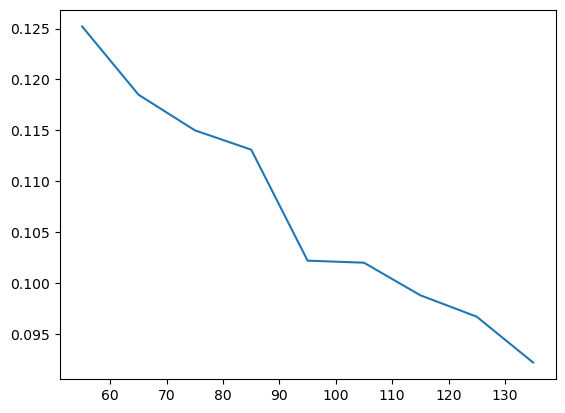

In [183]:
# param = "mu"
# param_num = "0"
param = "c_mean1"
param_num = None
stat = "sd"

s = summary_stats
if param_num==None:
    s0 = s[(s["param"]==param)]
else:
    s0 = s[(s["param"]==param)&(s["param_num"]==param_num)]

plt.plot(s0["n_raters"], s0[stat])
plt.show()

In [156]:
a = s[(s["param"]=="za")].groupby("n_raters").agg({"sd":"mean"}).reset_index().rename(columns={"sd":"za_sd"})
b = s[(s["param"]=="sigma_a")].groupby("n_raters").agg({"mean":"mean"}).reset_index().rename(columns={"mean":"sigma_mean"})
c= pd.merge(a, b, on="n_raters")

In [158]:
c["effective_topic_var"] = c["za_sd"]*c["sigma_mean"]

Text(0.5, 1.0, 'pvalue decreasing as n_raters increase')

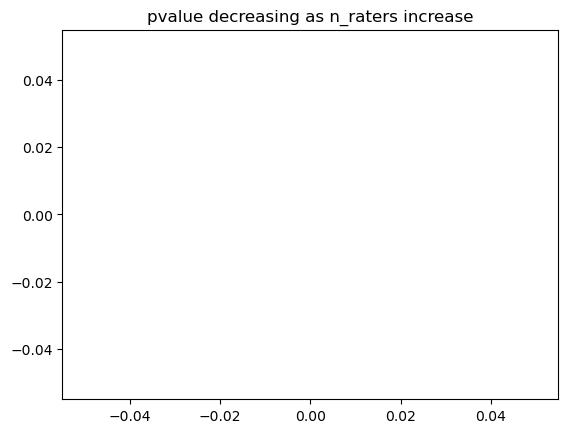

In [163]:
aa = s[(s["param"]=="za")&(s["param_num"]=="0, 0")]
plt.plot(aa["n_raters"], aa["p_val"])
plt.title("pvalue decreasing as n_raters increase")